In this notebook, we provide an first example of modeling using spatial data. The goal is to predict air monthly air temperature using satellite based measurements from Land Surface Temeperature from MODIS. The goal is to use the relationship using between satellite measurements and ground temperature meteorological station within a regression model. We predict temperature for the month of January and July 2010. The MODIS layers provided are monthly long term averages over the 2001 to 2012 time period. 

First, we set up the code by providing information on the Authors, creation dates and importing packages used in the code. 

In [1]:
#################################### Regression Temperature #######################################
######################## Analyze and predict air temperature with Earth Observation data #######################################
#This script performs analyses to predict air temperature using several coveriates.
#The goal is to predict air temperature using Remotely Sensing data as well as compare measurements
# from the ground station to the remotely sensed measurements.
#
#AUTHORS: Benoit Parmentier
#DATE CREATED: 09/07/2018
#DATE MODIFIED: 03/22/2019
#Version: 1
#PROJECT: SESYNC Geospatial Course and AAG 2019 Python Geospatial Course
#TO DO:
#
#COMMIT: clean up code for workshop
#
#################################################################################################

###### Library used in this script
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import georasters as gr
import gdal
import rasterio
import descartes
import pysal as ps
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict
import webcolors
import sklearn


The packages above are some of the most frequently used for geospatial data analysis and processing. Notables ones are geopandas, rasterio, pysal, gdal, shapely. Geopandas extends the pandas package to allow for the use of spatial data using a geometry column. It implements a version of the Simple Feature model. Rasterio allows operations and processing on raster. Shapely provides the geometry types used in geopandas. Another important library is sklearn that contains some of the most widely known machine learning and regression models (e.g. OLS linear regression, randomForest, svm etc.).  

In the next part of the script, we declare functions used in the sripts. The first function builds outputs directory while the second function helps in the fitting and testing of the regression model.

In [2]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

def fit_ols_reg(avg_df,selected_features,selected_target,prop=0.3,random_seed=100):
    #Function to fit a regressio model given a data frame

    X_train, X_test, y_train, y_test = train_test_split(avg_df[selected_features], 
                                                    avg_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
    
    from sklearn.linear_model import LinearRegression
    regr = LinearRegression().fit(X_train,y_train)

    regr.fit(X_train, y_train)

    y_pred_train = regr.predict(X_train) # Note this is a fit!
    y_pred_test = regr.predict(X_test) # Note this is a fit!

    r2_val_train = regr.score(X_train, y_train) #coefficient of determination (R2)
    r2_val_test = regr.score(X_test, y_test)

    from sklearn import metrics
    #https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

    mae_val_test = metrics.mean_absolute_error(y_test, y_pred_test) #MAE
    rmse_val_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)) #RMSE
    mae_val_train = metrics.mean_absolute_error(y_train, y_pred_train) #MAE
    rmse_val_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)) #RMSE
    
    data = np.array([[mae_val_test,rmse_val_test,r2_val_test],
                     [mae_val_train,rmse_val_train,r2_val_train]])
    data_metrics_df = pd.DataFrame(data,columns=['mae','rmse','r2'])
    data_metrics_df['test']=[1,0]
    
    X_test['test'] = 1
    X_train['test'] = 0
    y_test['test'] = 1
    y_train['test'] = 0
    
    X = pd.concat([X_train,X_test],sort=False)
    y = pd.concat([y_train,y_test],sort=False)
    ### return a tuple, could be a dict or list?
    
    residuals_val_test = y_test[selected_target] - y_pred_test
    residuals_val_train = y_train[selected_target] - y_pred_train
    residuals_val_test['test'] = 1   
    residuals_val_train['test'] = 0   
        
    residuals_df = pd.concat([residuals_val_test,residuals_val_train],sort=False)
    
    return X, y, regr, residuals_df,data_metrics_df

It is good practice to set all parameters and input arguments at the beginning of the script.

In [13]:
############################################################################
#####  Parameters and argument set up ###########

#ARGS 1
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/data"
#ARGS 2
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/outputs"

in_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/data/"
out_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/outputs"

#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "exercise4_03032019" #output suffix for the files and ouptut folder
#ARGS 8
NA_value = -9999 # NA flag balue
file_format = ".tif"

#NLCD coordinate reference system: we will use this projection rather than TX.
CRS_reg = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
method_proj_val = "bilinear" # method option for the reprojection and resampling
gdal_installed = True #if TRUE, GDAL is used to generate distance files


#epsg 2991
crs_reg = "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

#infile = "mean_month1_rescaled.rst" # mean LST for January
infile_lst_month1 = "lst_mean_month1_rescaled.tif" 
infile_lst_month7 = "lst_mean_month7_rescaled.tif" 

infile_forest_perc =""
ghcn_filename = "ghcn_or_tmax_covariates_06262012_OR83M.shp" # climate stations

prop = 0.3
random_seed= 100


We start the script by first creating a new output directory.

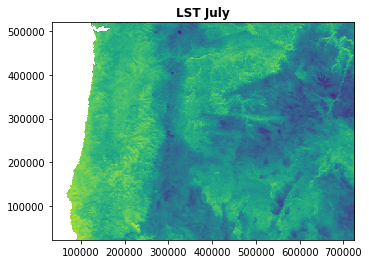

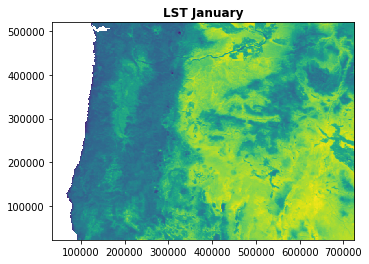

In [17]:
###########################################
### PART I: READ AND VISUALIZE DATA #######

data_gpd = gpd.read_file(os.path.join(in_dir,ghcn_filename))

data_gpd.head()  

## Extracting information from raster using raster io object
lst1 = rasterio.open(os.path.join(in_dir,infile_lst_month1))
lst7 = rasterio.open(os.path.join(in_dir,infile_lst_month7))
type(lst1)
lst1.crs # explore Coordinate Reference System 
lst1.shape
lst1.height
plot.show(lst1,title="LST July")
plot.show(lst7,title="LST January")


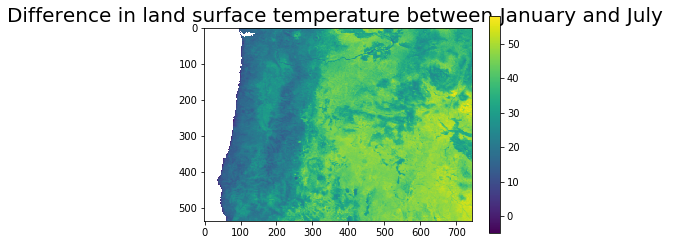

In [19]:
## Read raster bands directly to Numpy arrays and visualize data
r_lst1 = lst1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
r_lst7 = lst7.read(1,masked=True) #read first array with masked value, nan are assigned for NA

spatial_extent = rasterio.plot.plotting_extent(lst1)
type(r_lst1)
r_lst1.size

r_diff = r_lst7 - r_lst1
plt.imshow(r_diff) # other way to display data
plt.title("Difference in land surface temperature between January and July ", fontsize= 20)
plt.colorbar()


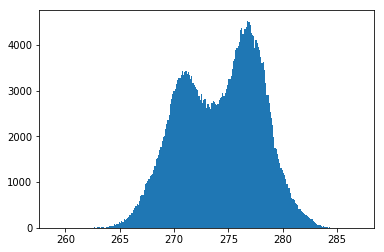

In [25]:
# Explore values distribution
plt.hist(r_lst1.ravel(),
         bins=256,
         range=(259.0,287.0));

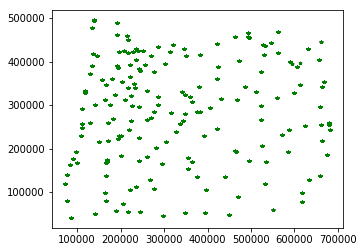

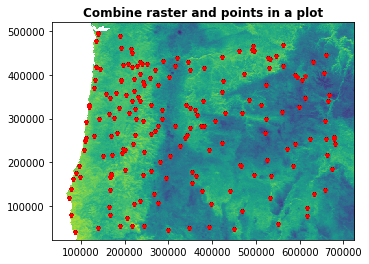

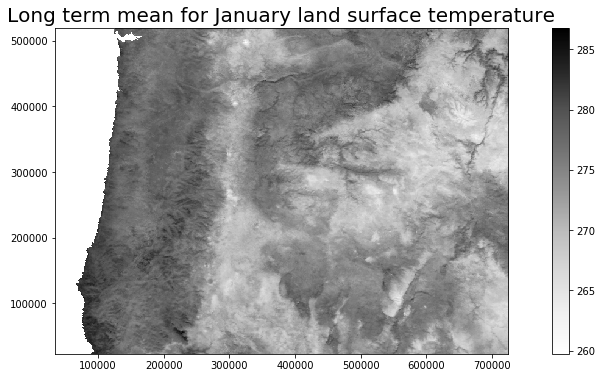

In [24]:
##### Combine raster layer and geogpanda layer

data_gpd.plot(marker="*",color="green",markersize=5)
station_or = data_gpd.to_crs({'init': 'epsg:2991'}) #reproject to  match the  raster image

##### How to combine plots with rasterio package
fig, ax = plt.subplots()
rasterio.plot.show(lst1,ax=ax,
                          clim=(259.0,287.0),
                  title="Combine raster and points in a plot")
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
               
##### How to combine plots with matplotlib package
fig, ax = plt.subplots(figsize = (16,6))
lst_plot = ax.imshow(r_lst1, 
                       cmap='Greys', 
                       extent=spatial_extent)
ax.set_title("Long term mean for January land surface temperature", fontsize= 20)
fig.colorbar(lst_plot)

#https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
# turn off the x and y axes for prettier plotting
#ax.set_axis_off(); #this removes coordinates on the plot


NameError: name 'infile' is not defined

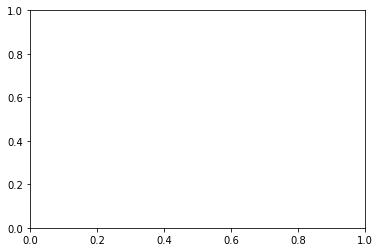

In [26]:
#https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/customize-matplotlib-raster-maps/
fig, ax = plt.subplots()
with rasterio.open(os.path.join(in_dir,infile)) as src:
        rasterio.plot.show((src,1),ax=ax,
                          clim=(259.0,287.0),)

#plot.show(r_lst, clim=(259.0, 287.0),ax=ax)
#with rasterio.plot.show((src,1),ax=ax)
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)

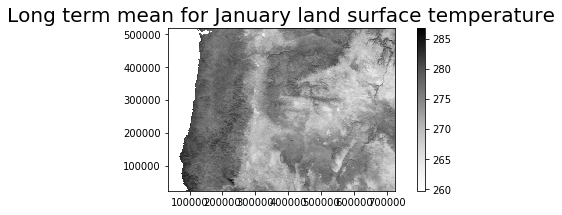

In [178]:
fig, ax = plt.subplots(figsize = (8,3))
lst_plot = ax.imshow(r_lst, 
                       cmap='Greys', 
                       extent=spatial_extent)
ax.set_title("Long term mean for January land surface temperature", fontsize= 20)
fig.colorbar(lst_plot)
# turn off the x and y axes for prettier plotting
#ax.set_axis_off(); #this removes coordinates on the plot

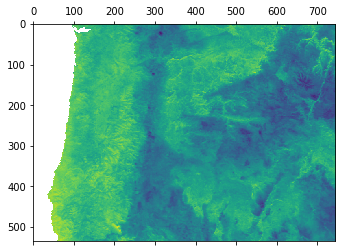

In [179]:
#raster = './data/slope.tif'
data=gr.from_file(os.path.join(in_dir,infile))
# Plot data
data.plot()

In [180]:
x_coord = station_or.geometry.x # pands.core.series.Series
y_coord = station_or.geometry.y

# Find value at point (x,y) or at vectors (X,Y)
values = data.map_pixel(x_coord,y_coord)
list(station_or) #get names of col
station_or['year'].value_counts()
station_or.groupby(['month'])['value'].mean()



month
1     -400.156785
2    -1241.282837
3     -267.490287
4     -594.049982
5     -328.350230
6     -563.981541
7     -198.206452
8     -306.864552
9     -592.981183
10    -494.211470
11    -720.368793
12    -339.014237
Name: value, dtype: float64

In [181]:
print("number of rows:",station_or.station.count(),"number of stations:",len(station_or.station.unique()))
station_or['LST1'] = value-273.15
station_or_jan = station_or.loc[(station_or['month']==1) & (station_or['value']!=-9999)]
station_or_jan.head()
#avg_df = station_or.groupby(['station'])['value'].mean())
avg_df = station_or_jan.groupby(['station'])['value','LST1'].mean()
avg_df['value']= avg_df['value']/10
avg_df.head()

number of rows: 67053 number of stations: 186


,value,LST1
station,,
USC00350036,6.640741,5.688080
USC00350118,7.542857,2.201294
USC00350145,10.064286,5.162262
USC00350197,7.183333,2.355988
USC00350265,7.061290,4.276459


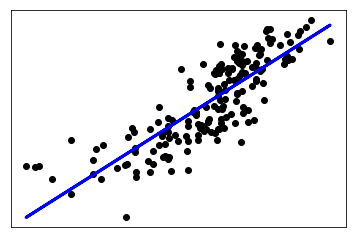

reg coef [[0.71763843]]
reg intercept [5.8663054]


0.6859319356294472

In [182]:
from sklearn.linear_model import LinearRegression
x=avg_df.LST1.values
y=avg_df.value.values
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)
regr = LinearRegression().fit(x,y)

#regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

print('reg coef',regr.coef_)
print('reg intercept',regr.intercept_)

reg.predict(x) # Note this is a fit!
reg.score(x, y)

